In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from tqdm import tqdm
from collections import defaultdict
import gseapy as gp
import anndata
from scipy import stats
from adjustText import adjust_text
from plot_utils import *
sns.set_style('whitegrid')

In [42]:
outdir = '../results'
figdir = f'{outdir}/overleaf/figures'
dataset = 'Norman2019'
seed = 0
file = f'../data/{dataset.lower()}/{dataset.lower()}_{seed}.h5ad'

In [3]:
adata = anndata.read_h5ad(file)

#### Enrichment analysis

In [59]:
df = adata.to_df().T
df.index = adata.var.loc[df.index]['gene_name']
adata.obs['control_str'] = adata.obs['control'].astype(str)
res = gp.gsea(data=df.reset_index(), # row -> genes, column-> samples
        gene_sets="GO_Biological_Process_2023",
        cls=adata.obs['control_str'].values,
        permutation_num=500,
        permutation_type='phenotype',
        min_size=5,
        max_size=1000,
        outdir=None,
        method='s2n', # signal_to_noise
        threads= 16)
# res.res2d.to_csv(f'{outdir}/{dataset}_gsea_bp.csv')

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/gseapy/gsea.py:105: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_std = df.groupby(by=cls_dict, axis=1).std(numeric_only=True)


/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/gseapy/plot.py:689: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


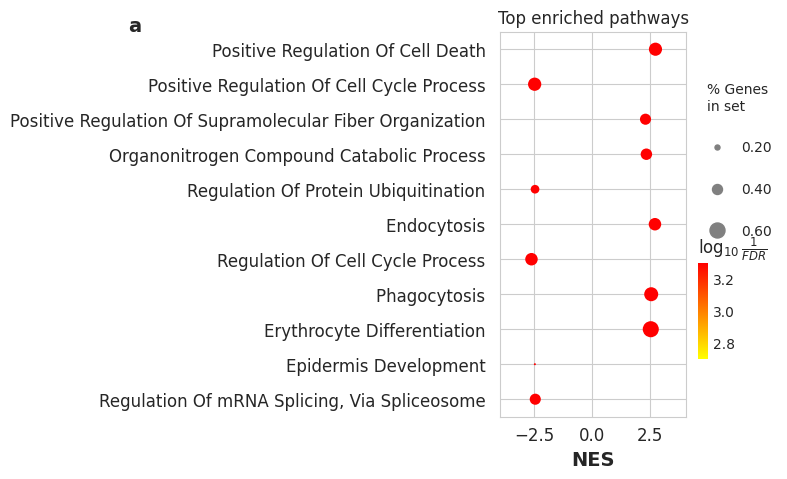

In [65]:
fontsize = 12
res_ = res.res2d.copy()
res_['Term'] = res_['Term'].str.split('(').str[0]
ax = gp.dotplot(res_,
           column='FDR q-val',
           figsize=(3,5),
           title="Enriched stress-related pathways",
           show_ring=False,
           size=3,
           top_term=11,
           cmap = plt.cm.autumn_r)
letter_annotation(ax, -2, 1, 'a', fontsize=14)
plt.yticks(fontsize=fontsize);
plt.xticks(fontsize=fontsize);
plt.xlabel('NES', fontsize=14);
plt.title('Top enriched pathways', fontsize=12);
plt.savefig(f'{figdir}/{dataset}_top_pathway_enrichment_fd.pdf', bbox_inches='tight');

In [63]:
# Select specific pathways
# keywords = ['heat', 'unfolded', 'dna damage', 'cell death', 'oxidative', 'stress', 'autophagy', 'apopt', 'external']
keywords = ['heat', 'unfolded', 'cell death', 'stress']
m = [any([k in x.lower() for k in keywords]) for x in res.res2d['Term'].values]
selected_pathways = np.unique(res.res2d['Term'].values[m])
res_selected = res.res2d[res.res2d['Term'].isin(selected_pathways)]

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/gseapy/plot.py:689: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


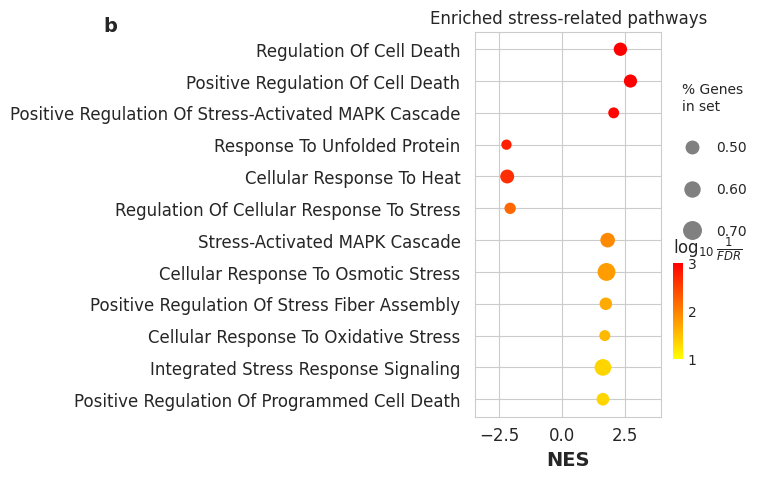

In [66]:
res_selected_ = res_selected.copy()
res_selected_['Term'] = res_selected_['Term'].str.split('(').str[0]
ax = gp.dotplot(res_selected_,
           column='FDR q-val',
           figsize=(3,5),
           title="Enriched stress-related pathways",
           show_ring=False,
           size=3,
           top_term=20,
           cmap = plt.cm.autumn_r)
letter_annotation(ax, -2, 1, 'b', fontsize=14)
# plt.ylabel(plt.gca().yaxis.get_label(), fontsize=4)
plt.yticks(fontsize=fontsize);
plt.xticks(fontsize=fontsize);
plt.xlabel('NES', fontsize=14);
plt.title('Enriched stress-related pathways', fontsize=12)
plt.savefig(f'{figdir}/{dataset}_stress_pathway_enrichment_fd.pdf', bbox_inches='tight');

#### Volcano plots

In [14]:
pvals = []
X = adata.layers['counts']
# X = 1e6 * X / X.sum(axis=1)[:, None]
X = np.log1p(X)
X_ctl = X[adata.obs['control'] == 1]
X_pert = X[adata.obs['control'] == 0]
for i in tqdm(range(adata.shape[-1])):
    t_statistic, p_values = stats.ttest_ind(X_pert[:, i], X_ctl[:, i])
    pvals.append(p_values)
pvals = np.array(pvals)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5045/5045 [00:16<00:00, 308.69it/s]


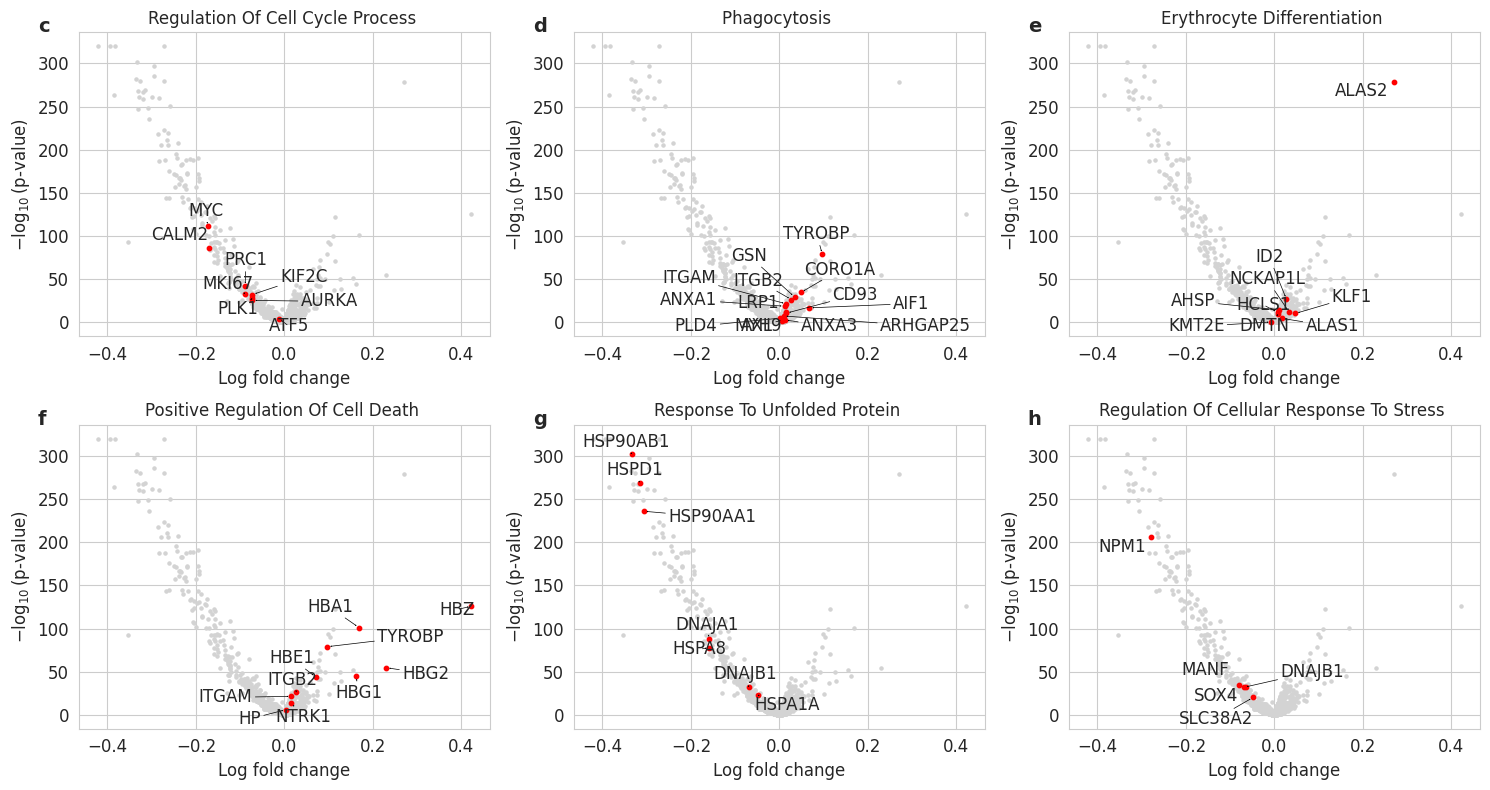

In [72]:
idxs = [2, 3, 4, 0, 44, 119]
nrows = 2
ncols = 3
fontsize=12
eps = 1e-320

x = X_pert.mean(0) - X_ctl.mean(0)
y = -np.log10(pvals + eps)
gene_names = adata.var['gene_name']
res_ = res.res2d.copy()
res_['Term'] = res_['Term'].str.split('(').str[0]
fig = plt.figure(figsize=(ncols*5, nrows*4))
for i, idx in enumerate(idxs):
    row = res_.loc[idx]
    plt.subplot(nrows, ncols, i+1)
    letter_annotation(plt.gca(), -.1, 1, chr(99 + i), fontsize=14)
    volcano_plot(x, y, row, gene_names, fontsize=fontsize)
plt.tight_layout()
plt.savefig(f'{figdir}/{dataset}_volcano_combined.pdf', bbox_inches='tight');